Example notebook showing how to use the MCMC sampler (currently in development)

In [1]:
import os
import sys
import argparse
import torch
from getdist import plots, MCSamples
import getdist
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import emcee

In [2]:
path = os.path.realpath(os.path.join(os.getcwd(), '../..'))
sys.path.insert(0, path)

In [3]:
from nnest import MCMCSampler
from nnest.likelihoods import *
from nnest.priors import *

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [25]:
# Likelihood
#like = Himmelblau(2)
#prior = UniformPrior(2, -5, 5)
#like = Rosenbrock(2)
#prior = UniformPrior(2, -2, 5)
#like = Gaussian(2, 0.9)
#prior = UniformPrior(2, -5, 5)
#like = Eggbox(2)
#prior = UniformPrior(2, -15, 15)
like = GaussianShell(2)
#prior = UniformPrior(2, -3, 3)
#like = GaussianMix(2)
#prior = UniformPrior(2, -8, 8)
#like = DoubleGaussianShell(2, centers=[[-4.0, 0.0], [4.0, 0.0]])
#prior = UniformPrior(2, [-7, -3], [7, 3])

In [26]:
sampler = MCMCSampler(like.x_dim, like, hidden_dim=16, num_blocks=3, flow='spline', prior=prior, run_num=1)

[nnest.trainer] [INFO] SingleSpeedSpline(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): ActNorm()
      (1): Invertible1x1Conv()
      (2): NSF_CL(
        (f1): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
            (5): LeakyReLU(negative_slope=0.2)
            (6): Linear(in_features=16, out_features=23, bias=True)
          )
        )
        (f2): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
        

INFO:nnest.trainer:SingleSpeedSpline(
  (flow): NormalizingFlow(
    (flows): ModuleList(
      (0): ActNorm()
      (1): Invertible1x1Conv()
      (2): NSF_CL(
        (f1): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
            (5): LeakyReLU(negative_slope=0.2)
            (6): Linear(in_features=16, out_features=23, bias=True)
          )
        )
        (f2): MLP(
          (net): Sequential(
            (0): Linear(in_features=1, out_features=16, bias=True)
            (1): LeakyReLU(negative_slope=0.2)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): LeakyReLU(negative_slope=0.2)
            (4): Linear(in_features=16, out_features=16, bias=True)
            

[nnest.trainer] [INFO] Number of network params: [5844]


INFO:nnest.trainer:Number of network params: [5844]


[nnest.trainer] [INFO] Device [cpu]


INFO:nnest.trainer:Device [cpu]


[nnest.sampler] [INFO] Num base params [2]


INFO:nnest.sampler:Num base params [2]


[nnest.sampler] [INFO] Num derived params [0]


INFO:nnest.sampler:Num derived params [0]


[nnest.sampler] [INFO] Total params [2]


INFO:nnest.sampler:Total params [2]


In [51]:
init_samples, loglikes = sampler.init_samples(num_chains=20, mcmc_steps=50, propose_scale=1.0, temperature=1.0, burn_in=50)

[nnest.sampler] [INFO] Acceptance [0.1250] min ESS [0.8873] max ESS [1.0893] average jump [0.1099]


INFO:nnest.sampler:Acceptance [0.1250] min ESS [0.8873] max ESS [1.0893] average jump [0.1099]


In [52]:
like.num_evaluations

9080

In [53]:
init_samples = [init_samples[i, :, :].squeeze() for i in range(init_samples.shape[0])]
loglikes = [-loglikes[i, :].squeeze() for i in range(loglikes.shape[0])]

In [54]:
mc = MCSamples(samples=init_samples, loglikes=loglikes, ignore_rows=0.0)

Removed no burn in


In [55]:
print(mc.getEffectiveSamples())
print(mc.getMargeStats())
print(mc.getConvergeTests())

31.064288113482007
Marginalized limits: 0.68; 0.95; 0.99

parameter   mean           sddev          lower1         upper1         limit1 lower2         upper2         limit2 lower3         upper3         limit3 
param1     -1.5521187E-01  1.4122687E+00 -2.0242352E+00  1.7826191E+00  two   -2.4947515E+00  2.3580217E+00  two   -2.9387015E+00  2.8154485E+00  two     p_{1}
param2      4.4265240E-02  1.4199119E+00 -2.0217851E+00  1.9790545E+00  two   -2.0908580E+00  2.0019572E+00  two   -2.6708679E+00  2.5850246E+00  two     p_{2}

Parameter autocorrelation lengths (effective number of samples N_eff = tot weight/weight length)

            Weight Length   Sample length           N_eff
param1           1.96E-01            0.20            5196
param2           3.48E-01            0.35            2933


mean convergence stats using remaining chains
param sqrt(var(chain mean)/mean(chain var))

param1        2.0760  p_{1}
param2        1.4053  p_{2}

var(mean)/mean(var) for eigenvalues of covari

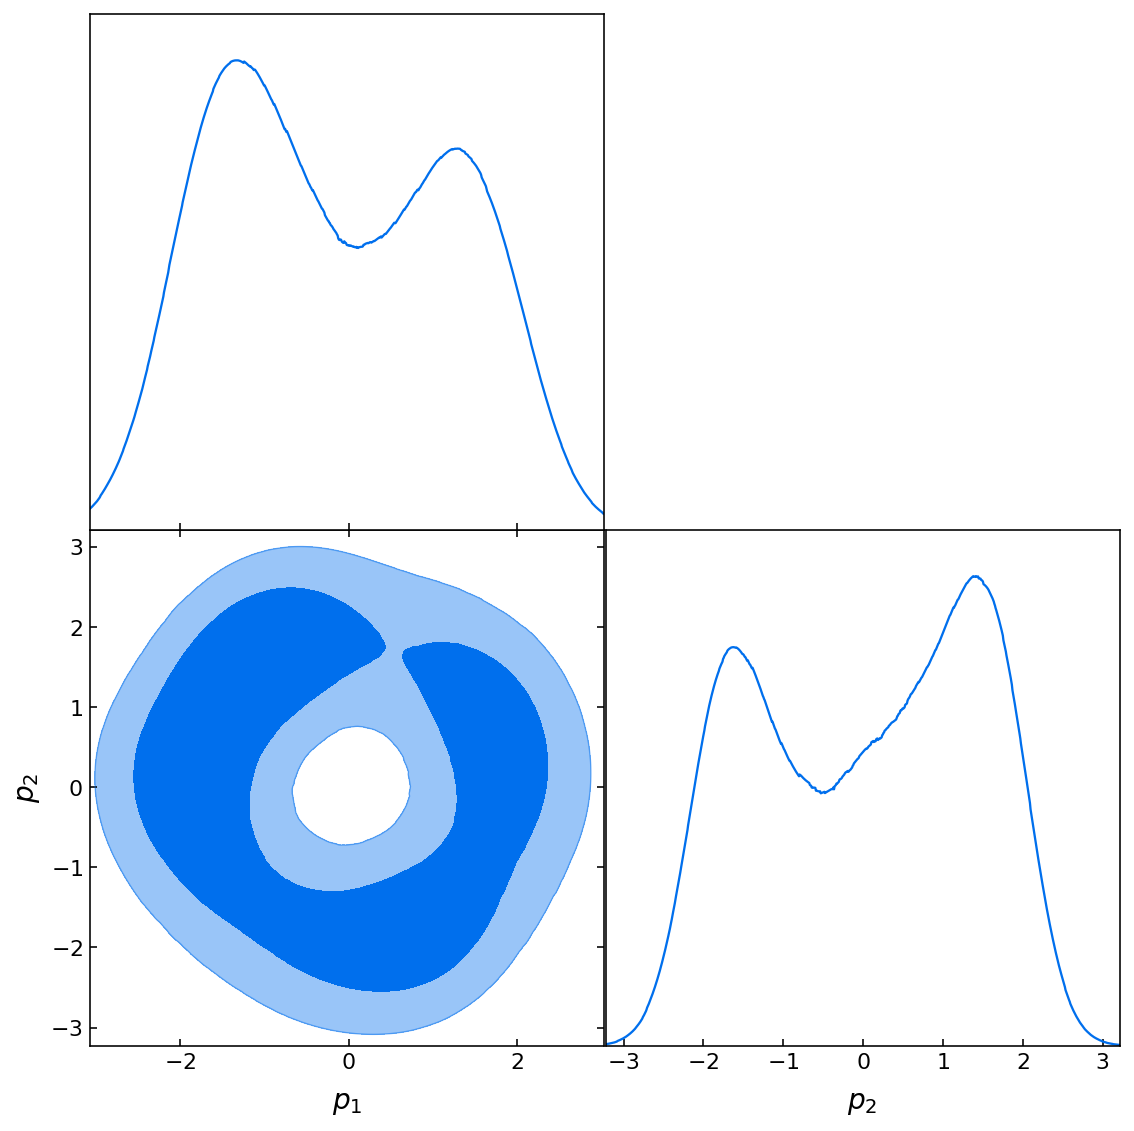

In [56]:
g = plots.getSubplotPlotter(width_inch=8)
g.triangle_plot(mc, filled=True)

In [57]:
init_samples = mc.makeSingleSamples(single_thin=10)

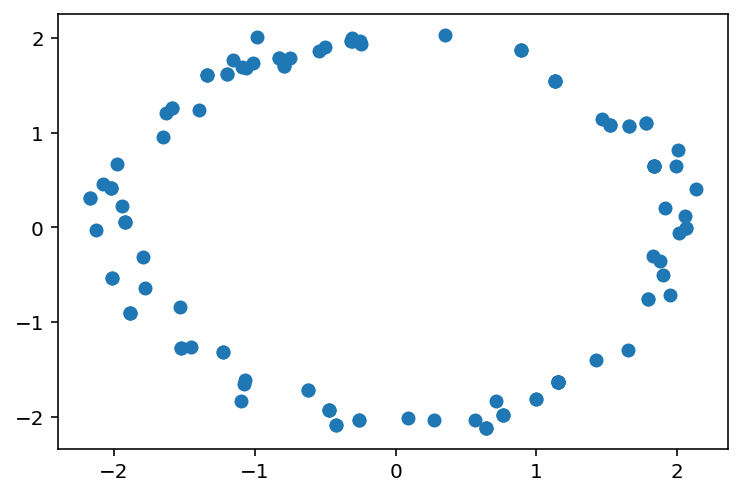

In [58]:
plt.scatter(init_samples[:,0], init_samples[:,1])
plt.show()

In [14]:
sampler.run(init_samples=init_samples)

[nnest.sampler] [INFO] Alpha [0.7071]


INFO:nnest.sampler:Alpha [0.7071]


[nnest.trainer] [INFO] Number of training samples [199]


INFO:nnest.trainer:Number of training samples [199]


[nnest.trainer] [INFO] Training jitter [0.2000]


INFO:nnest.trainer:Training jitter [0.2000]


[nnest.trainer] [INFO] Epoch [1] train loss [0.0328] validation loss [0.1373]


INFO:nnest.trainer:Epoch [1] train loss [0.0328] validation loss [0.1373]


[nnest.trainer] [INFO] Epoch [50] train loss [0.0281] validation loss [0.1142]


INFO:nnest.trainer:Epoch [50] train loss [0.0281] validation loss [0.1142]


[nnest.trainer] [INFO] Epoch [100] train loss [0.0248] validation loss [0.0962]


INFO:nnest.trainer:Epoch [100] train loss [0.0248] validation loss [0.0962]


[nnest.trainer] [INFO] Epoch [150] train loss [0.0225] validation loss [0.0806]


INFO:nnest.trainer:Epoch [150] train loss [0.0225] validation loss [0.0806]


[nnest.trainer] [INFO] Epoch [200] train loss [0.0208] validation loss [0.0655]


INFO:nnest.trainer:Epoch [200] train loss [0.0208] validation loss [0.0655]


[nnest.trainer] [INFO] Epoch [250] train loss [0.0192] validation loss [0.0587]


INFO:nnest.trainer:Epoch [250] train loss [0.0192] validation loss [0.0587]


[nnest.trainer] [INFO] Epoch [300] train loss [0.0194] validation loss [0.0561]


INFO:nnest.trainer:Epoch [300] train loss [0.0194] validation loss [0.0561]


[nnest.trainer] [INFO] Epoch [350] train loss [0.0195] validation loss [0.0562]


INFO:nnest.trainer:Epoch [350] train loss [0.0195] validation loss [0.0562]


[nnest.trainer] [INFO] Epoch [400] train loss [0.0201] validation loss [0.0534]


INFO:nnest.trainer:Epoch [400] train loss [0.0201] validation loss [0.0534]


[nnest.trainer] [INFO] Epoch [450] train loss [0.0200] validation loss [0.0531]


INFO:nnest.trainer:Epoch [450] train loss [0.0200] validation loss [0.0531]


[nnest.trainer] [INFO] Epoch [500] train loss [0.0175] validation loss [0.0539]


INFO:nnest.trainer:Epoch [500] train loss [0.0175] validation loss [0.0539]


[nnest.trainer] [INFO] Epoch [506] ran out of patience


INFO:nnest.trainer:Epoch [506] ran out of patience


[nnest.trainer] [INFO] Best epoch [456] validation loss [0.0525]


INFO:nnest.trainer:Best epoch [456] validation loss [0.0525]


[nnest.sampler] [INFO] Step [500] acceptance [0.4524] min ESS [11.3565] max ESS [13.2093] average jump [0.1301]


INFO:nnest.sampler:Step [500] acceptance [0.4524] min ESS [11.3565] max ESS [13.2093] average jump [0.1301]


[nnest.sampler] [INFO] Bootstrap step [1], ncalls [2584], nsamples [2505] scale [0.2693]


INFO:nnest.sampler:Bootstrap step [1], ncalls [2584], nsamples [2505] scale [0.2693]


[nnest.trainer] [INFO] Number of training samples [2704]


INFO:nnest.trainer:Number of training samples [2704]


[nnest.trainer] [INFO] Training jitter [0.1525]


INFO:nnest.trainer:Training jitter [0.1525]


[nnest.trainer] [INFO] Epoch [1] train loss [0.0169] validation loss [0.0045]


INFO:nnest.trainer:Epoch [1] train loss [0.0169] validation loss [0.0045]


[nnest.trainer] [INFO] Epoch [50] train loss [0.0143] validation loss [0.0036]


INFO:nnest.trainer:Epoch [50] train loss [0.0143] validation loss [0.0036]


[nnest.trainer] [INFO] Epoch [100] train loss [0.0144] validation loss [0.0036]


INFO:nnest.trainer:Epoch [100] train loss [0.0144] validation loss [0.0036]


[nnest.trainer] [INFO] Epoch [129] ran out of patience


INFO:nnest.trainer:Epoch [129] ran out of patience


[nnest.trainer] [INFO] Best epoch [79] validation loss [0.0035]


INFO:nnest.trainer:Best epoch [79] validation loss [0.0035]


[nnest.sampler] [INFO] Step [500] acceptance [0.5180] min ESS [10.8572] max ESS [17.7514] average jump [0.1738]


INFO:nnest.sampler:Step [500] acceptance [0.5180] min ESS [10.8572] max ESS [17.7514] average jump [0.1738]


[nnest.sampler] [INFO] Bootstrap step [2], ncalls [5257], nsamples [2505] scale [0.7768]


INFO:nnest.sampler:Bootstrap step [2], ncalls [5257], nsamples [2505] scale [0.7768]


[nnest.trainer] [INFO] Number of training samples [5000]


INFO:nnest.trainer:Number of training samples [5000]


[nnest.trainer] [INFO] Training jitter [0.1050]


INFO:nnest.trainer:Training jitter [0.1050]


[nnest.trainer] [INFO] Epoch [1] train loss [0.0110] validation loss [0.0014]


INFO:nnest.trainer:Epoch [1] train loss [0.0110] validation loss [0.0014]


[nnest.trainer] [INFO] Epoch [50] train loss [0.0102] validation loss [0.0012]


INFO:nnest.trainer:Epoch [50] train loss [0.0102] validation loss [0.0012]


[nnest.trainer] [INFO] Epoch [100] train loss [0.0100] validation loss [0.0011]


INFO:nnest.trainer:Epoch [100] train loss [0.0100] validation loss [0.0011]


[nnest.trainer] [INFO] Epoch [116] ran out of patience


INFO:nnest.trainer:Epoch [116] ran out of patience


[nnest.trainer] [INFO] Best epoch [66] validation loss [0.0011]


INFO:nnest.trainer:Best epoch [66] validation loss [0.0011]


[nnest.sampler] [INFO] Step [500] acceptance [0.4900] min ESS [16.0469] max ESS [27.9097] average jump [0.2684]


INFO:nnest.sampler:Step [500] acceptance [0.4900] min ESS [16.0469] max ESS [27.9097] average jump [0.2684]


[nnest.sampler] [INFO] Bootstrap step [3], ncalls [7865], nsamples [2505] scale [0.4262]


INFO:nnest.sampler:Bootstrap step [3], ncalls [7865], nsamples [2505] scale [0.4262]


[nnest.trainer] [INFO] Number of training samples [5000]


INFO:nnest.trainer:Number of training samples [5000]


[nnest.trainer] [INFO] Training jitter [0.0575]


INFO:nnest.trainer:Training jitter [0.0575]


[nnest.trainer] [INFO] Epoch [1] train loss [0.0071] validation loss [0.0006]


INFO:nnest.trainer:Epoch [1] train loss [0.0071] validation loss [0.0006]


[nnest.trainer] [INFO] Epoch [50] train loss [0.0057] validation loss [0.0004]


INFO:nnest.trainer:Epoch [50] train loss [0.0057] validation loss [0.0004]


[nnest.trainer] [INFO] Epoch [100] train loss [0.0057] validation loss [0.0004]


INFO:nnest.trainer:Epoch [100] train loss [0.0057] validation loss [0.0004]


[nnest.trainer] [INFO] Epoch [108] ran out of patience


INFO:nnest.trainer:Epoch [108] ran out of patience


[nnest.trainer] [INFO] Best epoch [58] validation loss [0.0004]


INFO:nnest.trainer:Best epoch [58] validation loss [0.0004]


[nnest.sampler] [INFO] Step [500] acceptance [0.5084] min ESS [13.0410] max ESS [27.3633] average jump [0.3685]


INFO:nnest.sampler:Step [500] acceptance [0.5084] min ESS [13.0410] max ESS [27.3633] average jump [0.3685]


[nnest.sampler] [INFO] Bootstrap step [4], ncalls [10458], nsamples [2505] scale [0.6009]


INFO:nnest.sampler:Bootstrap step [4], ncalls [10458], nsamples [2505] scale [0.6009]


[nnest.trainer] [INFO] Number of training samples [5000]


INFO:nnest.trainer:Number of training samples [5000]


[nnest.trainer] [INFO] Training jitter [0.0100]


INFO:nnest.trainer:Training jitter [0.0100]


[nnest.trainer] [INFO] Epoch [1] train loss [0.0012] validation loss [-0.0000]


INFO:nnest.trainer:Epoch [1] train loss [0.0012] validation loss [-0.0000]


[nnest.trainer] [INFO] Epoch [50] train loss [-0.0007] validation loss [-0.0002]


INFO:nnest.trainer:Epoch [50] train loss [-0.0007] validation loss [-0.0002]


[nnest.trainer] [INFO] Epoch [100] train loss [-0.0009] validation loss [-0.0002]


INFO:nnest.trainer:Epoch [100] train loss [-0.0009] validation loss [-0.0002]


[nnest.trainer] [INFO] Epoch [150] train loss [-0.0010] validation loss [-0.0002]


INFO:nnest.trainer:Epoch [150] train loss [-0.0010] validation loss [-0.0002]


[nnest.trainer] [INFO] Epoch [200] train loss [-0.0010] validation loss [-0.0002]


INFO:nnest.trainer:Epoch [200] train loss [-0.0010] validation loss [-0.0002]


[nnest.trainer] [INFO] Epoch [240] ran out of patience


INFO:nnest.trainer:Epoch [240] ran out of patience


[nnest.trainer] [INFO] Best epoch [190] validation loss [-0.0002]


INFO:nnest.trainer:Best epoch [190] validation loss [-0.0002]


[nnest.sampler] [INFO] Step [500] acceptance [0.5064] min ESS [29.8637] max ESS [44.5793] average jump [0.4531]


INFO:nnest.sampler:Step [500] acceptance [0.5064] min ESS [29.8637] max ESS [44.5793] average jump [0.4531]


[nnest.sampler] [INFO] Bootstrap step [5], ncalls [12771], nsamples [2505] scale [1.0458]


INFO:nnest.sampler:Bootstrap step [5], ncalls [12771], nsamples [2505] scale [1.0458]


[nnest.trainer] [INFO] Number of training samples [5000]


INFO:nnest.trainer:Number of training samples [5000]


[nnest.trainer] [INFO] Training jitter [0.0100]


INFO:nnest.trainer:Training jitter [0.0100]


[nnest.trainer] [INFO] Epoch [1] train loss [-0.0011] validation loss [-0.0002]


INFO:nnest.trainer:Epoch [1] train loss [-0.0011] validation loss [-0.0002]


[nnest.trainer] [INFO] Epoch [50] train loss [-0.0017] validation loss [-0.0002]


INFO:nnest.trainer:Epoch [50] train loss [-0.0017] validation loss [-0.0002]


[nnest.trainer] [INFO] Epoch [100] train loss [-0.0017] validation loss [-0.0003]


INFO:nnest.trainer:Epoch [100] train loss [-0.0017] validation loss [-0.0003]


[nnest.trainer] [INFO] Epoch [150] train loss [-0.0017] validation loss [-0.0003]


INFO:nnest.trainer:Epoch [150] train loss [-0.0017] validation loss [-0.0003]


[nnest.trainer] [INFO] Epoch [200] train loss [-0.0017] validation loss [-0.0003]


INFO:nnest.trainer:Epoch [200] train loss [-0.0017] validation loss [-0.0003]


[nnest.trainer] [INFO] Epoch [250] train loss [-0.0017] validation loss [-0.0003]


INFO:nnest.trainer:Epoch [250] train loss [-0.0017] validation loss [-0.0003]


[nnest.trainer] [INFO] Epoch [300] train loss [-0.0018] validation loss [-0.0002]


INFO:nnest.trainer:Epoch [300] train loss [-0.0018] validation loss [-0.0002]


[nnest.trainer] [INFO] Epoch [350] train loss [-0.0018] validation loss [-0.0003]


INFO:nnest.trainer:Epoch [350] train loss [-0.0018] validation loss [-0.0003]


[nnest.trainer] [INFO] Epoch [400] train loss [-0.0018] validation loss [-0.0003]


INFO:nnest.trainer:Epoch [400] train loss [-0.0018] validation loss [-0.0003]


[nnest.trainer] [INFO] Epoch [432] ran out of patience


INFO:nnest.trainer:Epoch [432] ran out of patience


[nnest.trainer] [INFO] Best epoch [382] validation loss [-0.0003]


INFO:nnest.trainer:Best epoch [382] validation loss [-0.0003]


[nnest.sampler] [INFO] Step [200] acceptance [0.5900] min ESS [9.8104] max ESS [16.8814] average jump [0.4666]


INFO:nnest.sampler:Step [200] acceptance [0.5900] min ESS [9.8104] max ESS [16.8814] average jump [0.4666]


[nnest.sampler] [INFO] Step [400] acceptance [0.5900] min ESS [18.4390] max ESS [30.9281] average jump [0.4683]


INFO:nnest.sampler:Step [400] acceptance [0.5900] min ESS [18.4390] max ESS [30.9281] average jump [0.4683]


[nnest.sampler] [INFO] Step [600] acceptance [0.5853] min ESS [26.0063] max ESS [27.8405] average jump [0.4689]


INFO:nnest.sampler:Step [600] acceptance [0.5853] min ESS [26.0063] max ESS [27.8405] average jump [0.4689]


[nnest.sampler] [INFO] Step [800] acceptance [0.5915] min ESS [34.1227] max ESS [41.8940] average jump [0.4710]


INFO:nnest.sampler:Step [800] acceptance [0.5915] min ESS [34.1227] max ESS [41.8940] average jump [0.4710]


[nnest.sampler] [INFO] Step [1000] acceptance [0.5870] min ESS [47.1225] max ESS [59.7278] average jump [0.4709]


INFO:nnest.sampler:Step [1000] acceptance [0.5870] min ESS [47.1225] max ESS [59.7278] average jump [0.4709]


[nnest.sampler] [INFO] Step [1200] acceptance [0.5872] min ESS [60.0433] max ESS [78.5431] average jump [0.4706]


INFO:nnest.sampler:Step [1200] acceptance [0.5872] min ESS [60.0433] max ESS [78.5431] average jump [0.4706]


[nnest.sampler] [INFO] Step [1400] acceptance [0.5827] min ESS [71.2200] max ESS [97.4808] average jump [0.4671]


INFO:nnest.sampler:Step [1400] acceptance [0.5827] min ESS [71.2200] max ESS [97.4808] average jump [0.4671]


[nnest.sampler] [INFO] Step [1600] acceptance [0.5837] min ESS [86.1815] max ESS [115.7200] average jump [0.4680]


INFO:nnest.sampler:Step [1600] acceptance [0.5837] min ESS [86.1815] max ESS [115.7200] average jump [0.4680]


[nnest.sampler] [INFO] Step [1800] acceptance [0.5820] min ESS [103.5310] max ESS [139.3483] average jump [0.4713]


INFO:nnest.sampler:Step [1800] acceptance [0.5820] min ESS [103.5310] max ESS [139.3483] average jump [0.4713]


[nnest.sampler] [INFO] Step [2000] acceptance [0.5810] min ESS [117.9881] max ESS [164.7147] average jump [0.4686]


INFO:nnest.sampler:Step [2000] acceptance [0.5810] min ESS [117.9881] max ESS [164.7147] average jump [0.4686]


[nnest.sampler] [INFO] Step [2200] acceptance [0.5824] min ESS [128.3578] max ESS [186.5065] average jump [0.4719]


INFO:nnest.sampler:Step [2200] acceptance [0.5824] min ESS [128.3578] max ESS [186.5065] average jump [0.4719]


[nnest.sampler] [INFO] Step [2400] acceptance [0.5816] min ESS [142.4296] max ESS [213.3554] average jump [0.4718]


INFO:nnest.sampler:Step [2400] acceptance [0.5816] min ESS [142.4296] max ESS [213.3554] average jump [0.4718]


[nnest.sampler] [INFO] Step [2600] acceptance [0.5821] min ESS [152.8934] max ESS [230.3304] average jump [0.4712]


INFO:nnest.sampler:Step [2600] acceptance [0.5821] min ESS [152.8934] max ESS [230.3304] average jump [0.4712]


[nnest.sampler] [INFO] Step [2800] acceptance [0.5812] min ESS [162.5231] max ESS [249.4817] average jump [0.4721]


INFO:nnest.sampler:Step [2800] acceptance [0.5812] min ESS [162.5231] max ESS [249.4817] average jump [0.4721]


[nnest.sampler] [INFO] Step [3000] acceptance [0.5803] min ESS [176.7842] max ESS [271.5979] average jump [0.4713]


INFO:nnest.sampler:Step [3000] acceptance [0.5803] min ESS [176.7842] max ESS [271.5979] average jump [0.4713]


[nnest.sampler] [INFO] Step [3200] acceptance [0.5797] min ESS [184.3511] max ESS [291.9095] average jump [0.4686]


INFO:nnest.sampler:Step [3200] acceptance [0.5797] min ESS [184.3511] max ESS [291.9095] average jump [0.4686]


[nnest.sampler] [INFO] Step [3400] acceptance [0.5790] min ESS [198.7412] max ESS [319.4627] average jump [0.4703]


INFO:nnest.sampler:Step [3400] acceptance [0.5790] min ESS [198.7412] max ESS [319.4627] average jump [0.4703]


[nnest.sampler] [INFO] Step [3600] acceptance [0.5787] min ESS [212.2979] max ESS [342.0875] average jump [0.4704]


INFO:nnest.sampler:Step [3600] acceptance [0.5787] min ESS [212.2979] max ESS [342.0875] average jump [0.4704]


[nnest.sampler] [INFO] Step [3800] acceptance [0.5791] min ESS [224.8825] max ESS [355.4904] average jump [0.4718]


INFO:nnest.sampler:Step [3800] acceptance [0.5791] min ESS [224.8825] max ESS [355.4904] average jump [0.4718]


[nnest.sampler] [INFO] Step [4000] acceptance [0.5771] min ESS [237.3895] max ESS [330.1883] average jump [0.4692]


INFO:nnest.sampler:Step [4000] acceptance [0.5771] min ESS [237.3895] max ESS [330.1883] average jump [0.4692]


[nnest.sampler] [INFO] Step [4200] acceptance [0.5780] min ESS [242.2580] max ESS [333.8389] average jump [0.4705]


INFO:nnest.sampler:Step [4200] acceptance [0.5780] min ESS [242.2580] max ESS [333.8389] average jump [0.4705]


[nnest.sampler] [INFO] Step [4400] acceptance [0.5768] min ESS [257.9205] max ESS [362.6168] average jump [0.4701]


INFO:nnest.sampler:Step [4400] acceptance [0.5768] min ESS [257.9205] max ESS [362.6168] average jump [0.4701]


[nnest.sampler] [INFO] Step [4600] acceptance [0.5767] min ESS [269.1675] max ESS [382.3958] average jump [0.4711]


INFO:nnest.sampler:Step [4600] acceptance [0.5767] min ESS [269.1675] max ESS [382.3958] average jump [0.4711]


[nnest.sampler] [INFO] Step [4800] acceptance [0.5775] min ESS [280.3845] max ESS [407.2923] average jump [0.4718]


INFO:nnest.sampler:Step [4800] acceptance [0.5775] min ESS [280.3845] max ESS [407.2923] average jump [0.4718]


[nnest.sampler] [INFO] Step [5000] acceptance [0.5768] min ESS [291.6756] max ESS [424.4958] average jump [0.4710]


INFO:nnest.sampler:Step [5000] acceptance [0.5768] min ESS [291.6756] max ESS [424.4958] average jump [0.4710]


ncall: 32807



In [15]:
like.num_evaluations

35857

In [18]:
samples = [sampler.samples[i, :, :].squeeze() for i in range(sampler.samples.shape[0])]
latent_samples = [sampler.latent_samples[i, :, :].squeeze() for i in range(sampler.latent_samples.shape[0])]
loglikes = [-sampler.loglikes[i, :].squeeze() for i in range(sampler.loglikes.shape[0])]

In [20]:
mc = MCSamples(samples=samples, loglikes=loglikes)

Removed no burn in


In [21]:
print(mc.getEffectiveSamples())
print(mc.getMargeStats())
print(mc.getConvergeTests())

1502.7971699186858
Marginalized limits: 0.68; 0.95; 0.99

parameter   mean           sddev          lower1         upper1         limit1 lower2         upper2         limit2 lower3         upper3         limit3 
param1      9.9269081E-01  7.0947180E-01  3.4037137E-01  1.7934234E+00  two   -2.6787265E-01  2.2434827E+00  two   -1.1675411E+00  2.3780871E+00  two     p_{1}
param2      1.4858231E+00  1.3808934E+00 -1.0930220E-01  1.9836898E+00  two   -1.5663927E-01  4.8760550E+00  two   -1.5934236E-01  4.8921745E+00  two     p_{2}

Parameter autocorrelation lengths (effective number of samples N_eff = tot weight/weight length)

            Weight Length   Sample length           N_eff
param1           1.66E+01           16.61            1505
param2           1.25E+01           12.51            1999


mean convergence stats using remaining chains
param sqrt(var(chain mean)/mean(chain var))

param1        0.0462  p_{1}
param2        0.0340  p_{2}

var(mean)/mean(var) for eigenvalues of covari

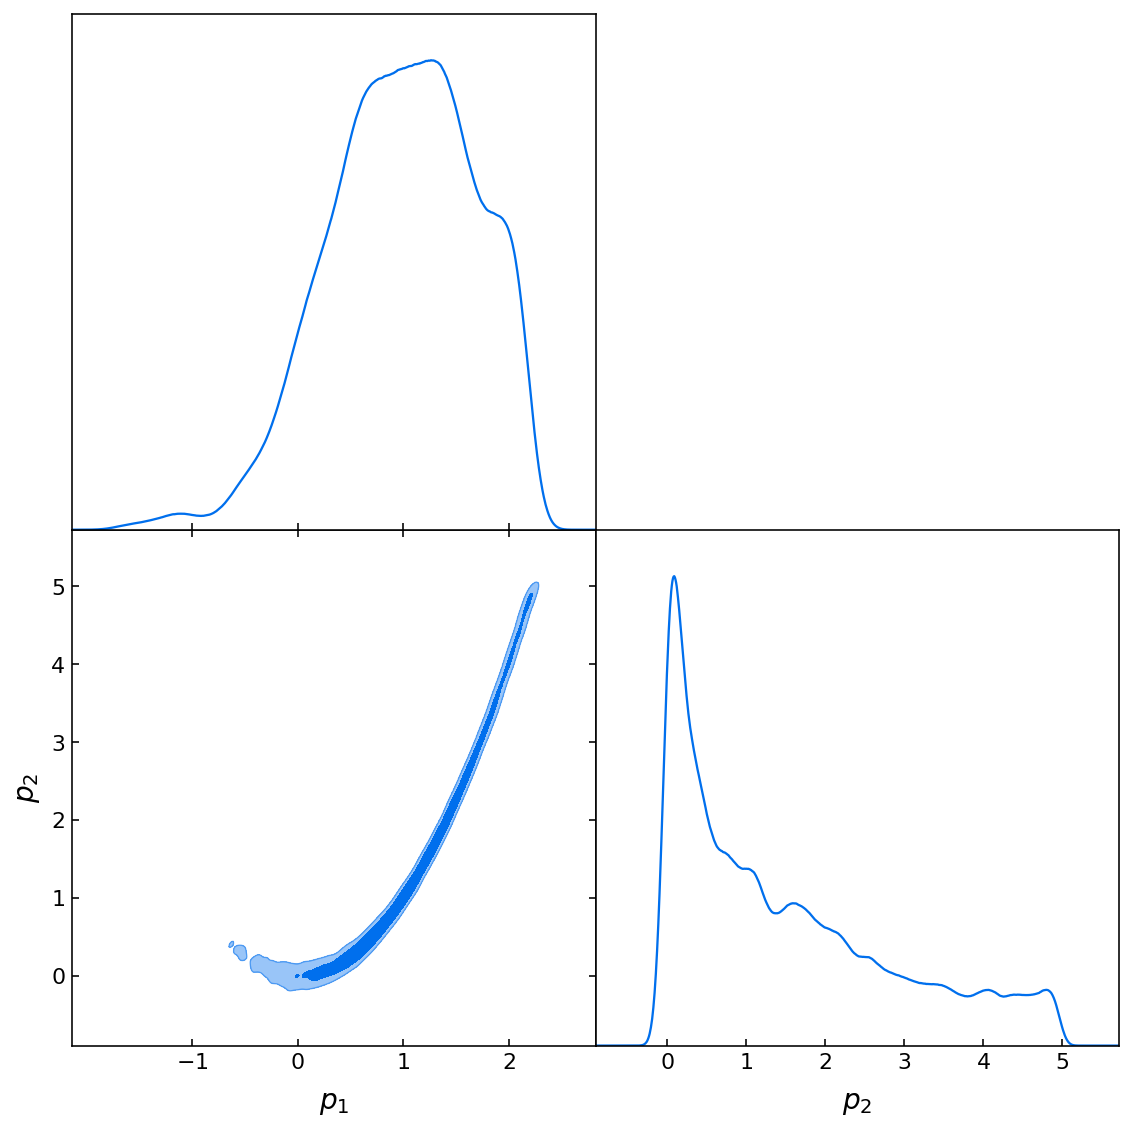

In [22]:
g = plots.getSubplotPlotter(width_inch=8)
g.triangle_plot(mc, filled=True)

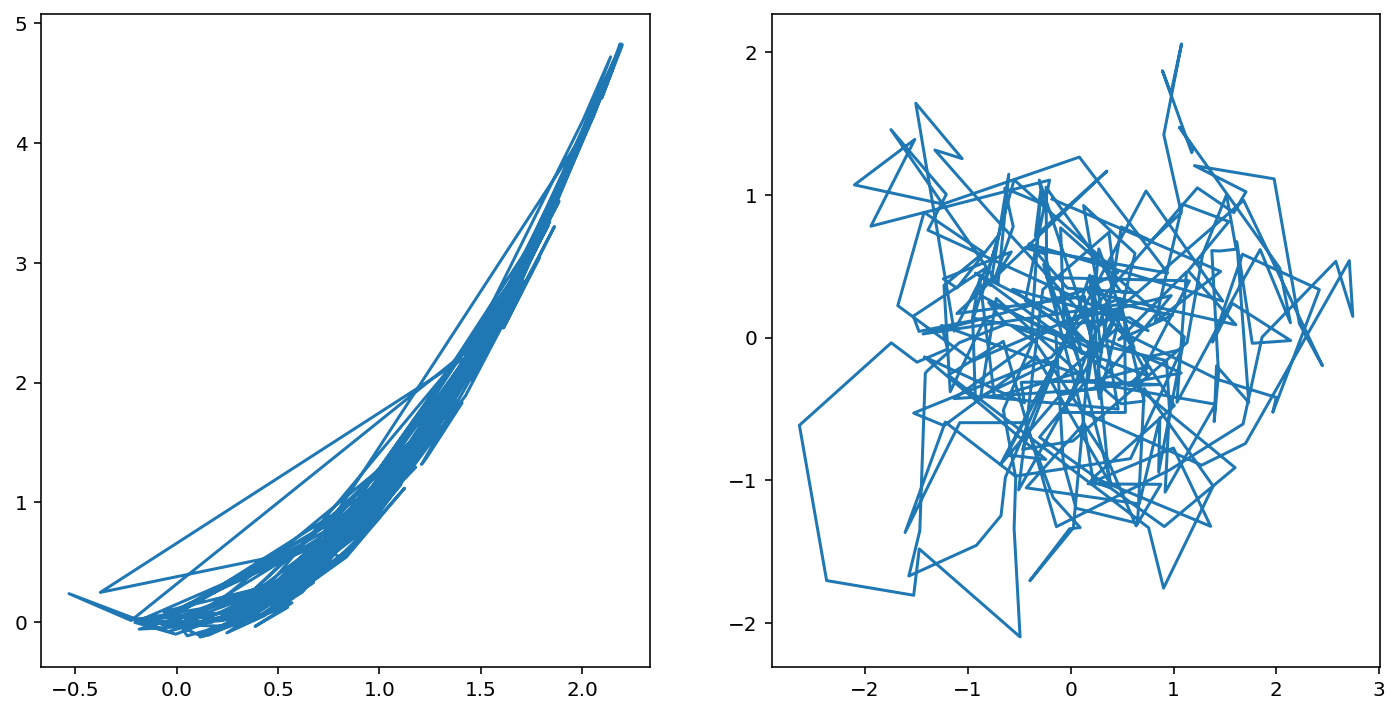

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(samples[0][500:1000,0], samples[0][500:1000,1])
ax[1].plot(latent_samples[0][500:1000,0], latent_samples[0][500:1000,1])
plt.show()

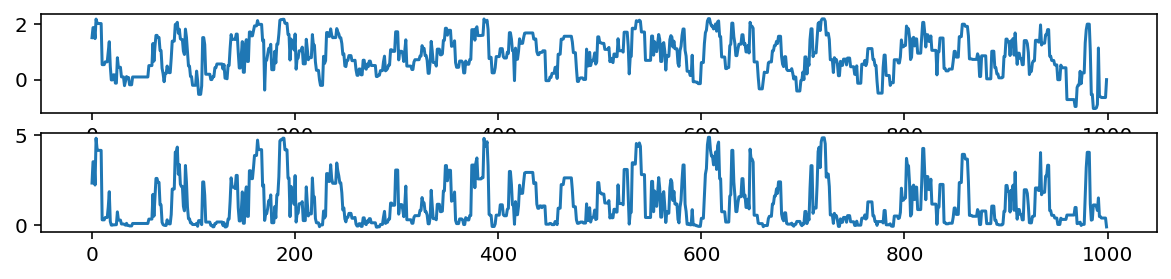

In [24]:
fig, ax = plt.subplots(like.x_dim, 1, figsize=(10, like.x_dim))
for i in range(like.x_dim):
    ax[i].plot(samples[0][500:1500,i])
plt.show()